<h3>Importing modules</h3>

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklhttp://localhost:8888/notebooks/Novartis%20Challange.ipynb#Importing-dataearn.metrics import recall_score
sns.set_style("whitegrid")

<h3>Importing data</h3>

In [46]:
train=pd.read_csv(r'C:\Users\My PC\Downloads\Dataset\Train.csv')
test=pd.read_csv(r'C:\Users\My PC\Downloads\Dataset\Test.csv')
submission=pd.read_csv(r'C:\Users\My PC\Downloads\Dataset\sample_submission.csv')

<h3>---------------------------Pre-processing-------------------------</h3>

In [47]:
test.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [48]:
INC=test['INCIDENT_ID']

<h3>Drop variables according to their importance (after the model has trained)</h3>

In [49]:
train.drop(['INCIDENT_ID','DATE'],axis=1,inplace=True)


In [50]:
test.drop(['INCIDENT_ID','DATE'],axis=1,inplace=True)

In [51]:
train.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [52]:
test.isnull().sum()

X_1       0
X_2       0
X_3       0
X_4       0
X_5       0
X_6       0
X_7       0
X_8       0
X_9       0
X_10      0
X_11      0
X_12    127
X_13      0
X_14      0
X_15      0
dtype: int64

In [53]:
train.isnull().sum()

X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64

<h3>Fill null values</h3>

In [54]:
test['X_12'].fillna(1,inplace=True)

In [55]:
train['X_12'].fillna(1,inplace=True)

<h3>Split in 75% train and 25% test set</h3>

In [56]:
train_df, test_df = train_test_split(train, test_size = 0.25, random_state= 1984)
train_y = train_df.MULTIPLE_OFFENSE
test_y = test_df.MULTIPLE_OFFENSE
train_x = train_df.drop(['MULTIPLE_OFFENSE'], axis = 1)
test_x = test_df.drop(['MULTIPLE_OFFENSE'], axis = 1)

In [57]:
train_data=lgb.Dataset(train_x, label=train_y)

<h3>------------------------Build LightGBM Model-----------------------</h3>

<h4>Select Hyper-Parameters</h4>

In [58]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

<h4>Create parameters to search</h4>

In [59]:
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

<h4>Create classifier to use</h4>

In [60]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [61]:
#View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.3s


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 16, 'num_leaves': 24, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.9865861837692823


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   22.0s finished


In [62]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 24, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


<h3>Train model on selected parameters and number of iterations</h3>

In [63]:
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

<h3>Predict on test set</h3>

In [64]:
predictions_lgbm_prob = lgbm.predict(test_x)

In [65]:
pred=lgbm.predict(test)

In [75]:
pred_lgbm_01 = np.where(pred > 0.45, 1, 0) 

In [67]:
pred_lgbm_01.size

15903

In [68]:
INC.count()

15903

In [70]:
submission.INCIDENT_ID = INC
submission.MULTIPLE_OFFENSE=pred_lgbm_01
submission.to_csv(r'C:\Users\My PC\Downloads\Dataset\submission.csv', index=False)

In [71]:
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.2, 1, 0) #Turn probability to 0-1 binary output


<h3>--------------------------Print accuracy measures and variable importances----------------------</h3>

<h4>Plot Variable Importances</h4>

Overall accuracy of Light GBM model: 0.9901073105298458


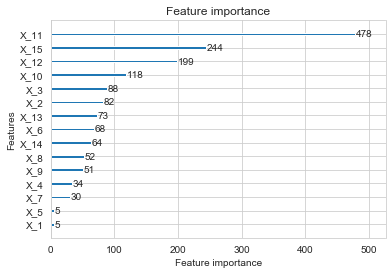

In [72]:
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)


<h4>Print Area Under Curve</h4>

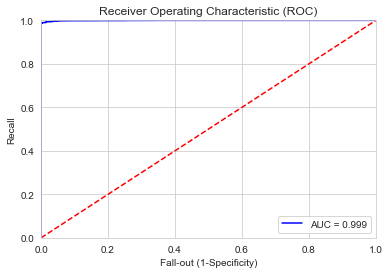

In [73]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

<h4>Print Confusion Matrix</h4>

<Figure size 432x288 with 0 Axes>

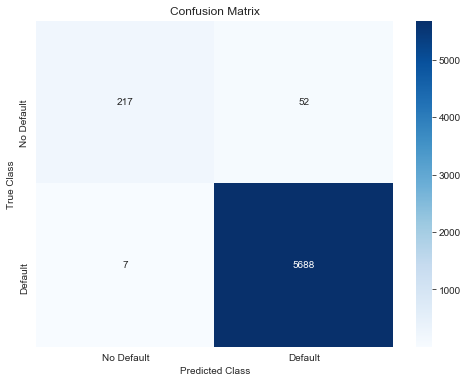

In [76]:
plt.figure()
cm = confusion_matrix(test_y, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()